In [2]:
!pip install cartopy

  Obtaining dependency information for cartopy from https://files.pythonhosted.org/packages/fb/96/02e0445ab41997f942e3d59c9fc3d08220e9b2651f85ac026a9dff7ce28f/Cartopy-0.23.0-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for shapely>=1.7 from https://files.pythonhosted.org/packages/2a/fb/e3f72b10a90e26bb1a92a38b3f30f3074ebac6d532f87848ac09c3e8a73b/shapely-2.0.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for pyshp>=2.3 from https://files.pythonhosted.org/packages/98/2f/68116db5b36b895c0450e3072b8cb6c2fac0359279b182ea97014d3c8ac0/pyshp-2.3.1-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for pyproj>=3.3.1 from https://files.pythonhosted.org/packages/30/bd/b9bd3761f08754e8dbb34c5a647db2099b348ab5da338e90980caf280e37/pyproj-3.6.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9

In [2]:
import cartopy.crs as ccrs
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = [12, 10]

## A Cautionary Tale

Let's start with a cautionary tale about mapping out a region of sky.  Let's say we wish to map the Galactic pole ($b=+90^\circ$) with a telescope that has an angular radius of $3^\circ$ (i.e. a FWHM of $6^\circ$). So we make an array of pointings spaced every $3^\circ$ in longitude and latitude covering those regions:

In [3]:
glats = range(20, 60, 2)
glons = range(60, 180, 2)
pointings = np.array([(L,b) for L in glons for b in glats])
print('Number of pointings:', pointings.shape[0])

Number of pointings: 1200


In [5]:
pointings[4]

array([60, 28])

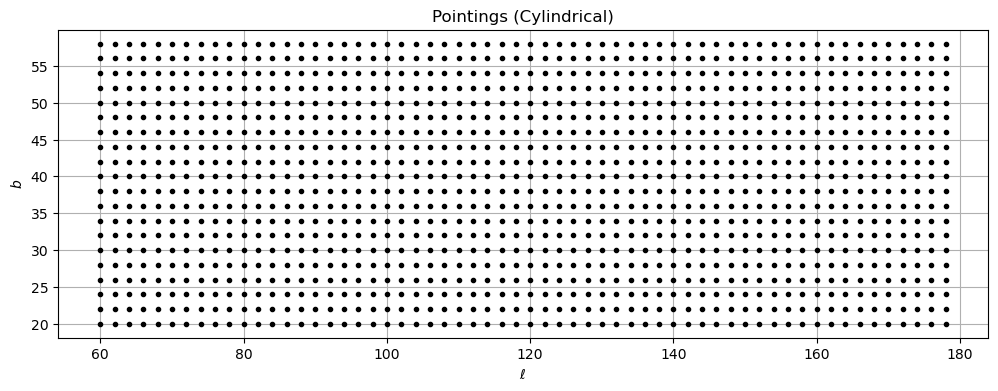

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(pointings[:,0], pointings[:,1], 'k.')
plt.grid()
plt.xlabel('$\ell$')
#plt.xlim(-183,183)
#plt.ylim(81,93)
plt.ylabel('$b$')
_ = plt.title('Pointings (Cylindrical)')

This looks like a nice, regularly-spaced grid of pointings. But it isn't.

In [18]:
import matplotlib.path as mpath

def add_circle_boundary(ax):
    '''Compute a circle in axes coordinates, which we can use as a boundary
    for the map. We can pan/zoom as much as we like - the boundary will be
    permanently circular.'''
    theta = np.linspace(0, 2*np.pi, 100)
    #center, radius = [0.5, 0.5], 0.5
    center, radius = [0.5, 0.5], 1
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

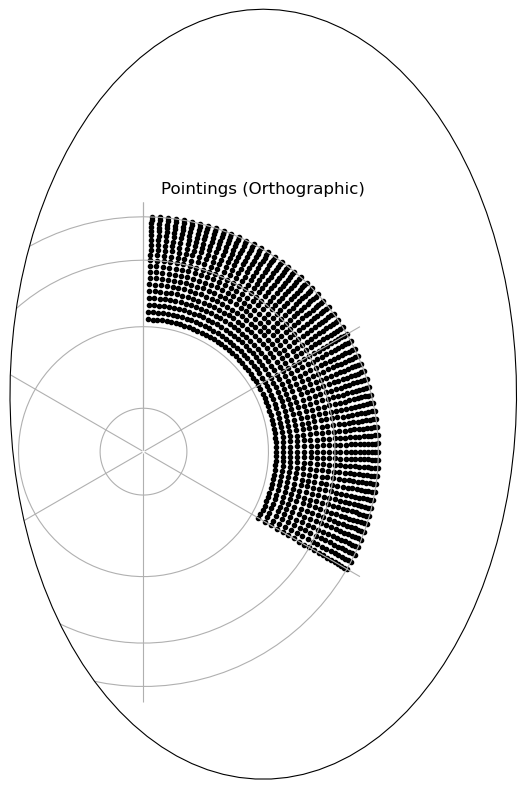

In [21]:
plt.figure(figsize=(5,5))

proj = ccrs.Orthographic(central_latitude=90)
geo = ccrs.Geodetic()
prj_pnts = proj.transform_points(geo, pointings[:,0], pointings[:,1])
ax = plt.axes(projection=proj)
ax.plot(prj_pnts[:,0], prj_pnts[:,1], 'k.')
add_circle_boundary(ax)
ax.gridlines()
_ = plt.title('Pointings (Orthographic)')

In the worst case, the entire top row of pointings mapped to one single point at the pole. The other rows are only marignally better: the longitudes may be spaced every $3^\circ$, but the actual separation between pointings on
the sky is much less than that.

We've spent 360 pointings covering about $\pi (6^\circ)^2\approx110$ square degrees on the sky (roughly 3 pointings per square degree), but our beam had an angular area of about 28 square degrees. We could have Nyquist sampled this region with about $110 / (28 / 4)\approx16$ pointings (the factor of 4 accounts for Nyquist sampling along two axes).

A better way to go about sampling this area is to define a more uniform grid away from the pole of this coordinate system, and then to shift it up here.

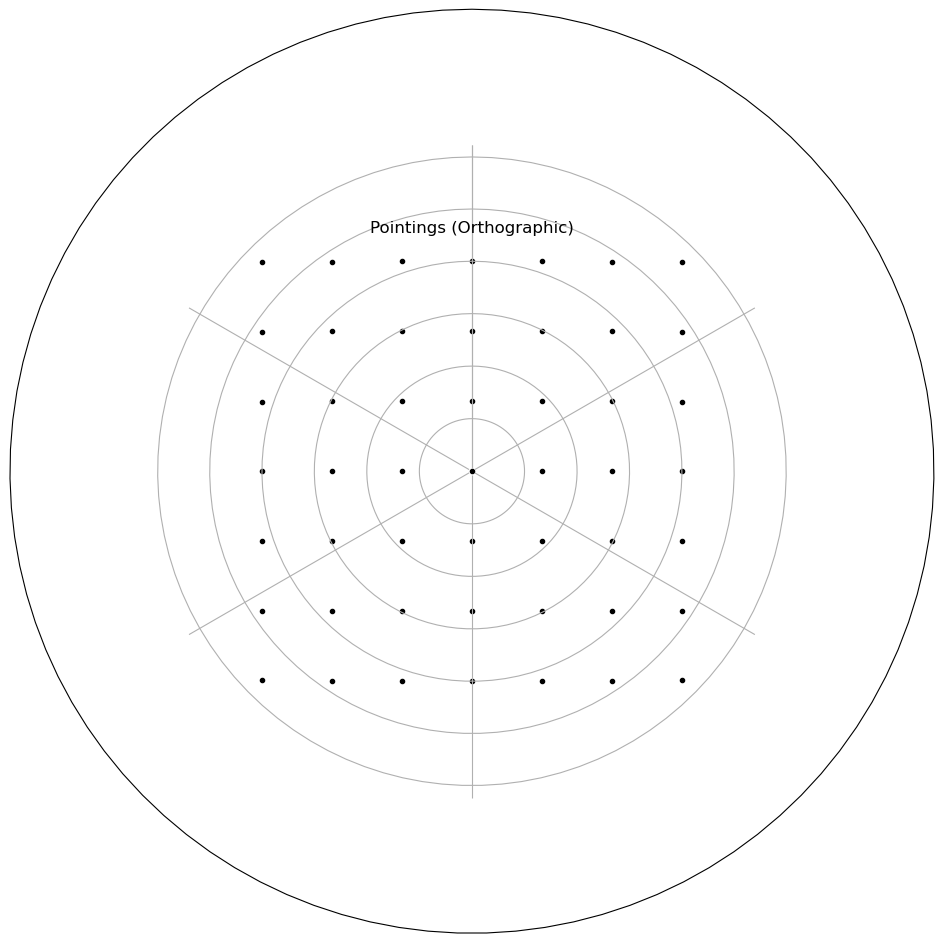

In [23]:
# define a center point along the x axis (orthogonal to the z pole)
theta0, phi0 = 90, 0 # deg

# build some uniform spacings around this center
ang_sep = 2 # deg
thetas = np.deg2rad(theta0 + ang_sep * np.arange(-3, 4))
phis = np.deg2rad(ang_sep * np.arange(-3, 4))

# convert angles to 3-vectors for easier rotation
x = np.outer(np.sin(thetas), np.cos(phis)).flatten()
y = np.outer(np.sin(thetas), np.sin(phis)).flatten()
z = np.outer(np.cos(thetas), np.ones_like(phis)).flatten()

# rotate the x coordinate up to the z axis
m = np.array([[ 0, 1, 0],
              [ 0, 0,-1],
              [ 1, 0, 0]])
x, y, z = np.dot(m, np.array([x, y, z]))

# turn 3-vectors back into angles
thetas = np.arctan2(np.sqrt(x**2 + y**2), z)
phis = np.arctan2(y, x)
lat = 90 - np.rad2deg(thetas)
lon = np.rad2deg(phis)

pointings = np.array([(L, b) for L, b in zip(lon, lat)])

plt.figure(figsize=(6,6))

proj = ccrs.Orthographic(central_latitude=90)
geo = ccrs.Geodetic()
prj_pnts = proj.transform_points(geo, pointings[:,0], pointings[:,1])
ax = plt.axes(projection=proj)
ax.plot(prj_pnts[:,0], prj_pnts[:,1], 'k.')
add_circle_boundary(ax)
ax.gridlines()
_ = plt.title('Pointings (Orthographic)')